# Imports


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, mean_absolute_error
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import pandas as pd

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


# Functions

In [ ]:
def fill_missing(features, fill_method='mean'):
    if fill_method in ["mean", "median"]:
        for col in features.columns:
            if fill_method == "mean":
                features[col] = features[col].fillna(features[col].mean())
            elif fill_method == "median":
                features[col] = features[col].fillna(features[col].median())
    elif fill_method == "knn":
        from sklearn.impute import KNNImputer
        imputer = KNNImputer(n_neighbors=5)
        features = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)


In [ ]:
def calculate_woe_iv(data, feature, target):
    bins = pd.qcut(data[feature], q=10, duplicates='drop')
    grouped = data.groupby(bins, observed=False)

    good = grouped[target].apply(lambda x: x[x == 0].count())
    bad = grouped[target].apply(lambda x: x[x == 1].count())
    total_good = good.sum()
    total_bad = bad.sum()

    good_ratio = good / total_good
    bad_ratio = bad / total_bad
    bad_ratio = bad_ratio.replace(0, 0.0001)
    good_ratio = good_ratio.replace(0, 0.0001)

    woe = np.log(good_ratio / bad_ratio)
    iv = (good_ratio - bad_ratio) * woe

    return woe, iv.sum()


def preprocess_and_select_features(df, target_column, thresh):
    data = df

    # Separate target and features
    target = data[target_column]
    features = data.drop(columns=[target_column])

    # Calculate IV for each feature
    iv_scores = {}
    for col in features.columns:
        try:
            _, iv = calculate_woe_iv(pd.concat([features, target], axis=1), col, target_column)
            iv_scores[col] = iv
        except:
            iv_scores[col] = 0

    # Sort features by IV and remove the ones which score below a particular threshold
    selected_features = [feature for feature, iv in iv_scores.items() if iv >= thresh]

    # Include selected features and the target column
    reduced_data = pd.concat([features[selected_features], target], axis=1)

    # Create a DataFrame from iv_scores dictionary
    iv_df = pd.DataFrame(list(iv_scores.items()), columns=["Feature", "IV"])

    return reduced_data, iv_df




In [ ]:
def preprocess(data):
  data = data.loc[:, data.nunique() > 1] #dropping all cols with only one unique value
  missing_percentage=(data.isnull().sum()/len(data))*100
  print("missing percentages:")
  print(missing_percentage)
  columns_to_drop = missing_percentage[missing_percentage > 80].index #dropping all cols with more than 80% missing values
  data = data.drop(columns=columns_to_drop)
  fill_missing(data, fill_method='mean') #filling the missing values with mean
  data.to_csv('filled_data.csv',index=False) #saving preprocessed data to csv file
  target_column = "bad_flag"
  data, iv_df = preprocess_and_select_features(data, target_column, thresh=0.01) ##TODO: thresh how much

# Preprocessing

In [ ]:
f_path='/content/drive/MyDrive/Dev_data_to_be_shared[1].csv' #reading the file
train_data=pd.read_csv(f_path)
f_path_val='/content/drive/MyDrive/validation_data_to_be_shared[1].csv'
val_data=pd.read_csv(f_path_val)

In [ ]:
preprocess(train_data)
columns = train_data.columns.tolist()
if 'bad_flag' in columns:
    columns.remove('bad_flag')
filtered_val_df = val_data[columns] #get the columns which are important from validation set

account_number              0.000000
bad_flag                    0.000000
onus_attribute_1           26.063467
transaction_attribute_1    26.063467
transaction_attribute_2    26.063467
                             ...    
onus_attribute_44          88.006942
onus_attribute_45          88.006942
onus_attribute_46          88.006942
onus_attribute_47          88.006942
onus_attribute_48          88.006942
Length: 1160, dtype: float64


In [ ]:
fill_missing(filtered_val_df)

In [ ]:
filtered_val_df.to_csv("reduced_val_dataset.csv", index=False) #save the reduced data

# Models

Ensemble

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/reduced_dataset with 0.1 thresh.csv')

In [ ]:
X = data.drop(columns=['bad_flag'])  # Replace with your target column
y = data['bad_flag']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
models = {
    "37_LightGBM": {"model": LGBMClassifier(random_state=37), "weight": 7},
    "39_Xgboost": {"model": XGBClassifier(random_state=39, use_label_encoder=False), "weight": 5},
    "41_LightGBM": {"model": LGBMClassifier(random_state=41), "weight": 3},
    "5_Default_Xgboost": {"model": XGBClassifier(random_state=5, use_label_encoder=False), "weight": 2},
    "6_Default_CatBoost": {"model": CatBoostClassifier(random_state=6, verbose=0), "weight": 2},
}

In [ ]:
probabilities = {}
for name, details in models.items():
    model = details["model"]
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    # Store probabilities for the target class 1
    probabilities[name] = model.predict_proba(X_test)[:, 1]

Training 37_LightGBM...
[LightGBM] [Info] Number of positive: 1102, number of negative: 76342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26576
[LightGBM] [Info] Number of data points in the train set: 77444, number of used features: 145
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014230 -> initscore=-4.238097
[LightGBM] [Info] Start training from score -4.238097
Training 39_Xgboost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training 41_LightGBM...
[LightGBM] [Info] Number of positive: 1102, number of negative: 76342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26576
[LightGBM] [Info] Number of data points in the train set: 77444, number of used features: 145
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014230 -> initscore=-4.238097
[LightGBM] [Info] Start training from score -4.238097
Training 5_Default_Xgboost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:47:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training 6_Default_CatBoost...


In [ ]:
total_weight = sum(details["weight"] for details in models.values())
ensemble_probability = np.zeros_like(list(probabilities.values())[0])

In [ ]:
for name, details in models.items():
    weight = details["weight"]
    ensemble_probability += weight * probabilities[name]

ensemble_probability /= total_weight

In [ ]:
roc_auc = roc_auc_score(y_test, ensemble_probability)
logloss = log_loss(y_test, ensemble_probability)
mae = mean_absolute_error(y_test, ensemble_probability)


In [ ]:
print(f"ROC-AUC Score of the ensemble: {roc_auc:.4f}")
print(f"Log Loss of the ensemble: {logloss:.4f}")
print(f"Mean Absolute Error (MAE) of the ensemble: {mae:.4f}")

ROC-AUC Score of the ensemble: 0.7930
Log Loss of the ensemble: 0.0674
Mean Absolute Error (MAE) of the ensemble: 0.0232


In [ ]:
results_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted_Probability": ensemble_probability
})
results_df.to_csv('results_df_ANOCA150',index=False)

In [ ]:
class_0 = results_df[results_df["Actual"] == 0]
class_1 = results_df[results_df["Actual"] == 1]

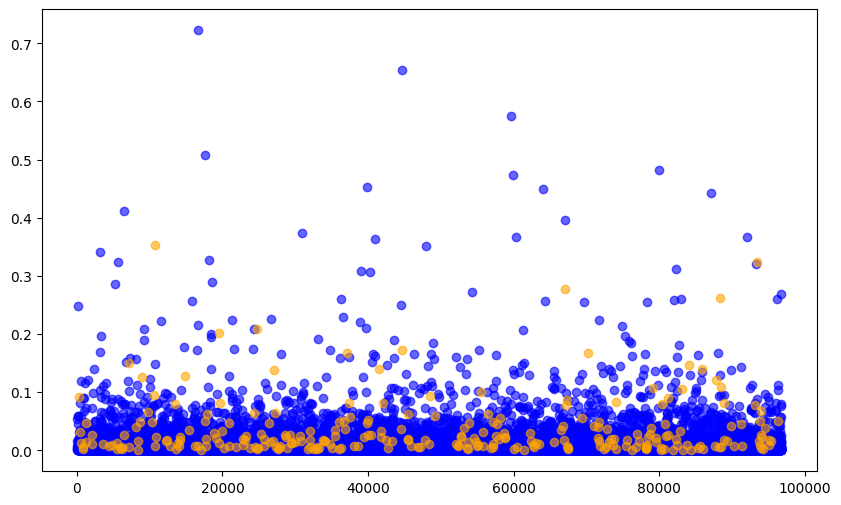

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(class_0.index, class_0["Predicted_Probability"], color="blue", alpha=0.6, label="Label 0")
plt.scatter(class_1.index, class_1["Predicted_Probability"], color="orange", alpha=0.6, label="Label 1")


In [ ]:
ensemble_probability

array([516.29128858,  43.76115462, 916.20397064, ...,  14.7947981 ,
       123.74162342,   1.89518829])

In [ ]:
threshold=0.5

In [ ]:
y_pred = (ensemble_probability > threshold).astype(int)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[18456   636]
 [  221    49]]


In [ ]:
cm_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

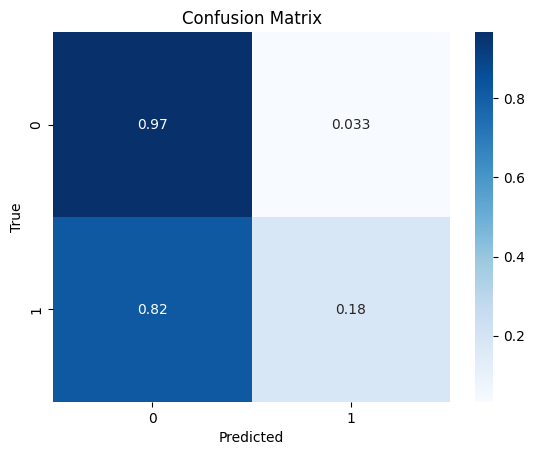

In [ ]:
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Neural Net

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/reduced_data_autoencoder2.csv')
# Remove the last row with NaN values
data_cleaned = data.dropna()

In [ ]:
# Split the data into features (X) and target labels (y)
X_cleaned = data_cleaned.iloc[:, 1:].values
y_cleaned = data_cleaned.iloc[:, 0].values


In [ ]:

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_cleaned, y_cleaned, test_size=0.4, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)


In [ ]:
# Scale the data for Neural Network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [ ]:
# Define the Neural Network model
class FeedforwardNN(nn.Module):
    def _init_(self, input_dim):
        super(FeedforwardNN, self)._init_()
        self.layer1 = nn.Linear(input_dim, 64)  # First hidden layer with 64 units
        self.layer2 = nn.Linear(64, 32)         # Second hidden layer with 32 units
        self.layer3 = nn.Linear(32, 32)         # Third hidden layer with 32 units
        self.layer4 = nn.Linear(32, 16)         # Fourth hidden layer with 16 units
        self.output_layer = nn.Linear(16, 1)    # Output layer with a single neuron

    def forward(self, x):
        x = torch.relu(self.layer1(x))  # ReLU activation on the first hidden layer
        x = torch.relu(self.layer2(x))  # ReLU activation on the second hidden layer
        x = torch.relu(self.layer3(x))  # ReLU activation on the third hidden layer
        x = torch.relu(self.layer4(x))  # ReLU activation on the fourth hidden layer
        x = self.output_layer(x)        # Linear output (no activation function)
        x = torch.sigmoid(x)            # Sigmoid activation for probabilities
        return x


In [ ]:
# Initialize the model
input_dim = X_train_scaled.shape[1]
model = FeedforwardNN(input_dim)
# Define loss function and optimizer
criterion_mse = nn.MSELoss()  # Mean Squared Error loss for regression
criterion_mae = nn.L1Loss()   # Mean Absolute Error loss for validation
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
num_epochs = 5000
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Zero the gradients
    y_train_pred = model(X_train_tensor)  # Forward pass
    loss = criterion_mse(y_train_pred, y_train_tensor)  # Compute MSE loss for training
    loss.backward()  # Backpropagate the gradients
    optimizer.step()  # Update the weights

    # Record training loss
    train_losses.append(loss.item())

    # Validation loss using MAE
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradients needed for validation
        y_val_pred = model(X_val_tensor)
        val_loss = criterion_mae(y_val_pred, y_val_tensor)  # Compute MAE for validation
        val_losses.append(val_loss.item())

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

# Make predictions on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).numpy()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_prob)
print(f'\nMean Squared Error (MSE): {mse:.4f}')

# Create a DataFrame with predicted probabilities and actual labels
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Prob': y_pred_prob.flatten()
})


In [ ]:

# Plot the training and validation losses over epochs
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss (MAE)')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
# For true label 1, show predicted labels in red
plt.scatter(range(len(y_test[y_test == 1])), y_pred_prob.flatten()[y_test == 1], color='red', label='Predicted Labels (True Label = 1)', alpha=0.5)
plt.scatter(range(len(y_test[y_test == 0])), y_pred_prob.flatten()[y_test == 0], color='green', label='Predicted Labels (True Label = 0)', alpha=0.5)
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.title('Neural Network Predictions vs True Labels')
plt.legend()
plt.show()